In [1]:
from physDBD import ImportHelper, DataDesc, ParamsTraj, RxnInputsLayer, ParamsTETraj, RxnModel, ConvertParams0ToNMomentsLayer, ComparisonModel, ComparisonInputsLayer, TrainingData, DataType
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_data_dir():
    data_dir = "/Users/oernst/Documents/papers/2021_03_draft/stochastic_simulations/ml_training_data/data_gillespie/"
    vol_exp = 14
    no_ip3r = 100
    vol_dir = "vol_exp_%02d" % vol_exp
    no_ip3r_dir = "ip3r_%05d" % no_ip3r
    data_dir = os.path.join(data_dir, vol_dir, no_ip3r_dir)
    return data_dir

# Transformation

## Calculate

In [5]:
data_desc = DataDesc(
    no_seeds=100,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [6]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

In [7]:
data["ip3_0p100"].shape

(400, 100, 2)

In [8]:
trans_means = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    trans_means[ip3] = np.mean(data[ip3],axis=(0,1))

print("Means: ", trans_means)    

trans_mean = np.mean(np.array(list(trans_means.values())),axis=0)
print("Means: ", trans_mean)

Means:  {'ip3_0p100': array([371.56195, 601.2577 ]), 'ip3_2p000': array([ 3451.841975, 12051.191425])}
Means:  [1911.7019625 6326.2245625]


In [9]:
sums = {}
lengths = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    ds = data[ip3].shape
    arr = np.reshape(pow(data[ip3] - trans_mean,2),(ds[0]*ds[1],ds[2]))
    rs = arr.shape
    sums[ip3] = np.sum(arr,axis=0)
    lengths[ip3] = rs[0]

length = np.sum(list(lengths.values()))
trans_std = np.sum(list(sums.values()), axis=0) / length
trans_std = np.sqrt(trans_std)

print("Std. devs: ", trans_std)

Std. devs:  [1729.21588444 5724.97054985]


## Export

In [10]:
np.savetxt("cache/trans_mean.txt",trans_mean)
np.savetxt("cache/trans_std.txt",trans_std)

## Import

In [11]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Plot

In [12]:
data_desc = DataDesc(
    no_seeds=1,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [13]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

Text(0.5, 0, 'Timepoint (x 0.1s)')

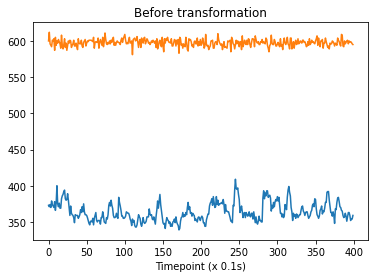

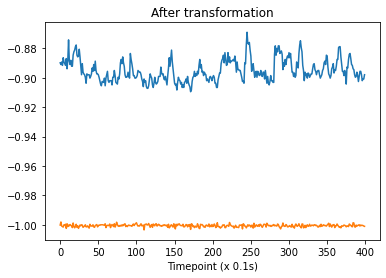

In [14]:
ex_traj = data["ip3_0p100"][:,0]

plt.figure()
plt.plot(ex_traj)
plt.title("Before transformation")
plt.xlabel("Timepoint (x 0.1s)")

plt.figure()
plt.plot((ex_traj - trans_mean)/trans_std)
plt.title("After transformation")
plt.xlabel("Timepoint (x 0.1s)")

# PCA params

## Import transformation

In [15]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Import, calculate PCA

In [16]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [17]:
if not os.path.isdir("cache/cache_params"):
    os.mkdir("cache/cache_params")

In [18]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    data = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(), ip3)
        )
    
    data = (data - trans_mean) / trans_std
    
    # Create params traj and export
    muh = np.zeros(1)
    varh_diag = np.ones(1)
    params_traj = ParamsTraj.fromPCA(data, data_desc.times, muh, varh_diag)

    # Export
    params_traj.export("cache/cache_params/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

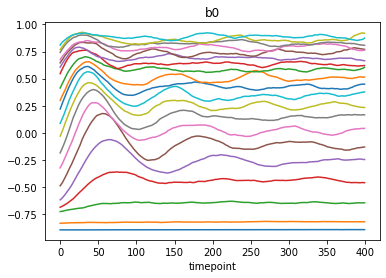

In [86]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)

    b0 = [x.b[0] for x in params_traj.params_traj]

    plt.plot(b0)

plt.title("b0")
plt.xlabel("timepoint")

plt.savefig("figures/params_b0.png", dpi=200)

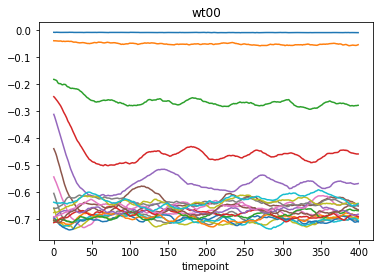

In [100]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)

    wt00 = [x.wt[0,0] for x in params_traj.params_traj]

    plt.plot(wt00)

plt.title("wt00")
plt.xlabel("timepoint")

plt.savefig("figures/params_wt00.png", dpi=200)

# Derivatives

In [20]:
if not os.path.isdir("cache/cache_derivs"):
    os.mkdir("cache/cache_derivs")

In [21]:
alphas = {
    "wt00": 100.0,
    "wt01": 5000.0,
    "b0": 100.0,
    "b1": 100.0,
    "sig2": 5000.0
}
non_zero_vals = list(alphas.keys())

In [22]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    # Differentiate
    paramsTE_traj = params_traj.differentiate_with_TVR(
        alphas=alphas, 
        no_opt_steps=10, 
        non_zero_vals=non_zero_vals
        )
    
    # Export
    paramsTE_traj.export("cache/cache_derivs/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

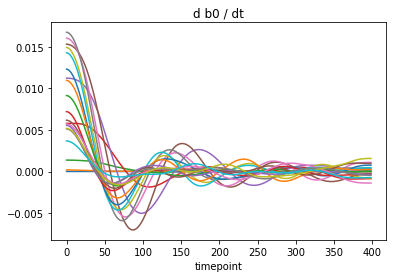

In [84]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    b0 = [x.b_TE[0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(b0)

plt.title("d b0 / dt")
plt.xlabel("timepoint")

plt.savefig("figures/derivs_b0.png", dpi=200)

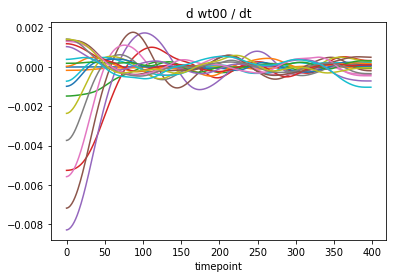

In [85]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    wt00 = [x.wt_TE[0,0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(wt00)

plt.title("d wt00 / dt")
plt.xlabel("timepoint")

plt.savefig("figures/derivs_wt00.png", dpi=200)

## Re-integrate

In [4]:
if not os.path.isdir("cache/cache_filtered"):
    os.mkdir("cache/cache_filtered")

In [5]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params and TE traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    b1 = np.array([p.b[1] for p in params_traj.params_traj])
    b1_mean = np.mean(b1)

    # Integrate
    no_steps = len(params_traj.params_traj) - 1
    params_traj_filtered = ParamsTraj.fromIntegrating(
        paramsTE_traj=paramsTE_traj,
        params_init=params_traj.params_traj[0],
        tpt_start=0,
        no_steps=no_steps,
        constant_vals_lf={
            "sig2": 1.5 * 1e-6,
            "b1": b1_mean,
            "wt01": 0.00005
        }
        )
    
    # Export
    params_traj_filtered.export("cache/cache_filtered/%s.txt" % ip3)

## Plot

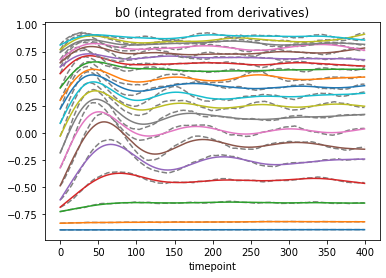

In [87]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj_filtered = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    b0_filtered = [x.b[0] for x in params_traj_filtered.params_traj]
    b0 = [x.b[0] for x in params_traj.params_traj]

    plt.plot(b0,color="gray",linestyle="dashed")
    plt.plot(b0_filtered)

plt.title("b0 (integrated from derivatives)")
plt.xlabel("timepoint")

plt.savefig("figures/filtered_b0.png", dpi=200)

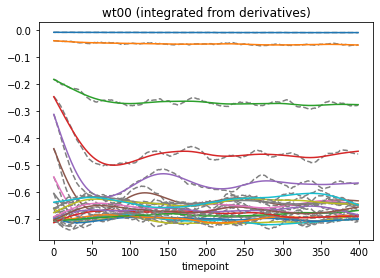

In [88]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj_filtered = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    wt00_filtered = [x.wt[0,0] for x in params_traj_filtered.params_traj]
    wt00 = [x.wt[0,0] for x in params_traj.params_traj]

    plt.plot(wt00,color="gray",linestyle="dashed")
    plt.plot(wt00_filtered)

plt.title("wt00 (integrated from derivatives)")
plt.xlabel("timepoint")

plt.savefig("figures/filtered_wt00.png", dpi=200)

# Network

In [4]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [5]:
# Freqs, coffs for fourier
freqs = np.array([1.,2.,3.,4.,5.,6.])
freqs = 2.0 * np.pi * freqs / data_desc.no_times

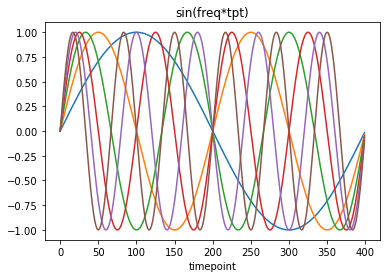

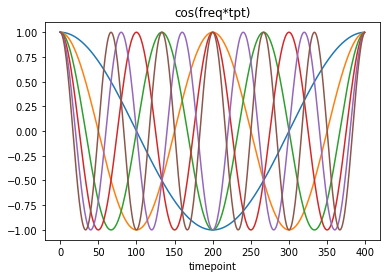

In [6]:
no_tpts = np.arange(0,data_desc.no_times)

plt.figure()
for freq in freqs:
    plt.plot(np.sin(freq * no_tpts))

plt.title("sin(freq*tpt)")
plt.xlabel("timepoint")
plt.savefig("figures/freqs_sin.png", dpi=200)

plt.figure()
for freq in freqs:
    plt.plot(np.cos(freq * no_tpts))

plt.title("cos(freq*tpt)")
plt.xlabel("timepoint")
plt.savefig("figures/freqs_cos.png", dpi=200)

## Reactions

In [7]:
# Rxns
rxn_specs = [
    ("EAT",0,1),
    ("EAT",1,0),
    ("EAT",2,0),
    ("EAT",0,2),
    ("EAT",1,2),
    ("EAT",2,1),
    ("BIRTH",0),
    ("BIRTH",1),
    ("BIRTH",2),
    ("DEATH",0),
    ("DEATH",1),
    ("DEATH",2)
    ]

In [8]:
# Reaction input layer
rxn_lyr = RxnInputsLayer.construct_zero_init(
    nv=2,
    nh=1,
    freqs=freqs,
    rxn_specs=rxn_specs
    )

## Subnet

In [9]:
# Shallow
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),
    tf.keras.layers.Dropout(0.5)
])

In [10]:

'''
# Deep
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3)
])
'''

'\n# Deep\nsubnet = tf.keras.Sequential([\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), t

## Model

In [11]:
model = RxnModel.construct(
    nv=2,
    nh=1,
    rxn_lyr=rxn_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

## Training data

In [12]:
td = TrainingData()
for ip3 in ["ip3_0p400","ip3_0p500","ip3_0p600","ip3_0p700",
            "ip3_0p800","ip3_0p900","ip3_1p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Training data
    td.reap_params_traj_for_inputs(params_traj, DataType.TRAINING)
    td.reap_paramsTE_traj_for_ouputs(paramsTE_traj, DataType.TRAINING, non_zero_outputs=["wt00_TE","b0_TE"])

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_1p100",
            "ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
            "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Validation data
    td.reap_params_traj_for_inputs(params_traj, DataType.VALIDATION)
    td.reap_paramsTE_traj_for_ouputs(paramsTE_traj, DataType.VALIDATION, non_zero_outputs=["wt00_TE","b0_TE"])

IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


In [15]:
# Normalize outputs
td.calculate_output_standardizations_and_apply(0.2)

td.write_output_standardizations("cache")

Calculating output normalization from: 558 samples


In [14]:
# Normalize inputs

# Reaction layer to use for the normalization
rxn_lyr_norm = RxnInputsLayer.construct_one_init(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]]),
    rxn_specs=rxn_specs
    )

# Normalize inputs
model.calculate_rxn_normalization(
    rxn_lyr=rxn_lyr_norm, 
    inputs=td.train_inputs, 
    percent=0.2
    )

Calculating input normalization from: 558 samples


In [16]:
print("Reaction normalization: Mean: ", model.rxn_mean)
print("Reaction normalization: Std dev: ", model.rxn_std_dev)

Reaction normalization: Mean:  [ 2.2178409e-01 -2.2178409e-01  6.4657621e-02 -6.4657621e-02
  6.4657114e-02 -2.2178409e-01  2.2178409e-01 -6.4657621e-02
  6.4657621e-02  6.4658128e-02  4.4253257e-01  1.7458842e-05
  6.1775821e-01  0.0000000e+00 -5.5381075e-02  3.6370867e-01
  1.7461001e-05 -6.1775821e-01  0.0000000e+00 -5.5380717e-02
  4.4092823e-02 -4.3140325e-01  0.0000000e+00 -7.8541804e-03
  2.3092255e-02  4.4092819e-02  3.1876814e-01  0.0000000e+00
  7.8541860e-03  2.3092197e-02 -6.2311465e-01  0.0000000e+00
 -2.9656660e-02  0.0000000e+00 -1.4826846e-02  0.0000000e+00
  4.9999922e-05  0.0000000e+00 -3.8301510e-01 -1.9150612e-01
 -1.2140328e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -7.8458406e-02  6.2311465e-01  0.0000000e+00  2.9656660e-02
  0.0000000e+00 -1.4829830e-02  0.0000000e+00 -4.9999922e-05
  0.0000000e+00  3.8301510e-01 -1.9150980e-01 -1.2140326e-01
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -7.8458384e-02]
Reaction normalization: Std dev:  [9.78642181e-02 9.7

# Train

In [17]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

# Log outputs for tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

# Write weights of lowest validation score
val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

# Train!
model.fit(
    td.train_inputs, 
    td.train_outputs_stdrd, 
    epochs=25, 
    validation_data=(td.valid_inputs,td.valid_outputs_stdrd),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

# Save
model.save("trained/trained_final", save_traces=False)

Epoch 1/25
44/44 [==============================] - 81s 558ms/step - loss: 2.2066 - b0_TE_loss: 1.1542 - wt00_TE_loss: 1.0524 - val_loss: 3.7867 - val_b0_TE_loss: 2.2433 - val_wt00_TE_loss: 1.5434

Epoch 00001: val_loss improved from inf to 3.78671, saving model to trained/weights_lowest_val
Epoch 2/25
44/44 [==============================] - 10s 226ms/step - loss: 1.2565 - b0_TE_loss: 0.6423 - wt00_TE_loss: 0.6142 - val_loss: 2.5034 - val_b0_TE_loss: 0.6528 - val_wt00_TE_loss: 1.8505

Epoch 00002: val_loss improved from 3.78671 to 2.50337, saving model to trained/weights_lowest_val
Epoch 3/25
44/44 [==============================] - 11s 247ms/step - loss: 0.8808 - b0_TE_loss: 0.4612 - wt00_TE_loss: 0.4196 - val_loss: 1.8349 - val_b0_TE_loss: 0.5027 - val_wt00_TE_loss: 1.3322

Epoch 00003: val_loss improved from 2.50337 to 1.83491, saving model to trained/weights_lowest_val
Epoch 4/25
44/44 [==============================] - 11s 254ms/step - loss: 0.7060 - b0_TE_loss: 0.3718 - wt00_TE_

# Analyze trained

In [18]:
model_trained = tf.keras.models.load_model("trained/trained_final")

# Load lowest validation weights
model_trained.load_weights("trained/weights_lowest_val")

## Integrate

In [19]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p600", nv=2, nh=1)
tpt_start = 0
params_start = params_traj.params_traj[tpt_start]

params_traj_int = model_trained.integrate(
    params_start=params_start,
    tpt_start=tpt_start,
    no_steps=400,
    time_interval=0.1,
    output_mean=td.train_outputs_mean,
    output_std_dev=td.train_outputs_std_dev
)

0 / 400 ...
40 / 400 ...
80 / 400 ...
120 / 400 ...
160 / 400 ...
200 / 400 ...
240 / 400 ...
280 / 400 ...
320 / 400 ...
360 / 400 ...


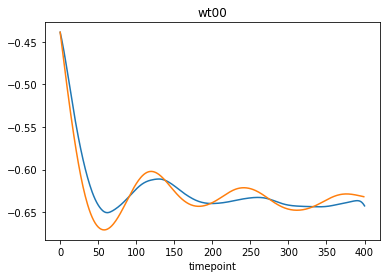

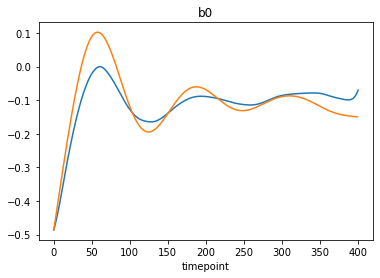

In [20]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)
plt.title("wt00")
plt.xlabel("timepoint")

plt.savefig("figures/integrated_wt00.png", dpi=200)

plt.figure()
plt.plot(b0)
plt.plot(b0_true)
plt.title("b0")
plt.xlabel("timepoint")

plt.savefig("figures/integrated_b0.png", dpi=200)

# Train comparison model

In [62]:
compare_lyr = ComparisonInputsLayer.construct_zero_init(
    nv=2,
    nh=1,
    freqs=freqs
    )

In [63]:
model = ComparisonModel.construct(
    nv=2,
    nh=1,
    compare_lyr=compare_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

In [64]:
# Reaction layer to use for the normalization
compare_lyr_norm = ComparisonInputsLayer.construct_one_init(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]])
    )

# Normalize inputs
model.calculate_param_normalization(
    compare_lyr=compare_lyr_norm,
    inputs=td.train_inputs, 
    percent=0.2
    )

Calculating input normalization from: 558 samples


In [65]:
print("Param normalization: Mean: ", model.param_mean)
print("Param normalization: Std dev: ", model.param_std_dev)

Param normalization: Mean:  [-7.0482546e-01  5.5520162e-05 -9.6994251e-02 -3.6622068e-01
  0.0000000e+00  2.2564167e-02  1.0325634e+00]
Param normalization: Std dev:  [2.5104061e-01 1.7341879e-05 4.4773069e-01 2.0861846e-01 1.0000000e+00
 5.0192004e-01 5.0191993e-01]


## Train

In [66]:
# Build model by running it once
input0 = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=0)
output0 = model(input0)

In [67]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

logdir = os.path.join("logs_compare", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained_compare/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

model.fit(
    td.train_inputs, 
    td.train_outputs_stdrd, 
    epochs=25, 
    validation_data=(td.valid_inputs,td.valid_outputs_stdrd),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

# Save
model.save("trained_compare/trained_final", save_traces=False)

Epoch 1/25
44/44 [==============================] - 4s 49ms/step - loss: 2.1117 - b0_TE_loss: 1.0736 - wt00_TE_loss: 1.0381 - val_loss: 0.7408 - val_b0_TE_loss: 0.4621 - val_wt00_TE_loss: 0.2787

Epoch 00001: val_loss improved from inf to 0.74081, saving model to trained_compare/weights_lowest_val
Epoch 2/25
44/44 [==============================] - 1s 25ms/step - loss: 1.7611 - b0_TE_loss: 0.8624 - wt00_TE_loss: 0.8987 - val_loss: 0.6291 - val_b0_TE_loss: 0.3712 - val_wt00_TE_loss: 0.2579

Epoch 00002: val_loss improved from 0.74081 to 0.62911, saving model to trained_compare/weights_lowest_val
Epoch 3/25
44/44 [==============================] - 1s 24ms/step - loss: 1.4226 - b0_TE_loss: 0.6712 - wt00_TE_loss: 0.7514 - val_loss: 0.6471 - val_b0_TE_loss: 0.3430 - val_wt00_TE_loss: 0.3041

Epoch 00003: val_loss did not improve from 0.62911
Epoch 4/25
44/44 [==============================] - 1s 26ms/step - loss: 1.1101 - b0_TE_loss: 0.5208 - wt00_TE_loss: 0.5893 - val_loss: 0.7577 - val_b0

# Analyze trained

In [68]:
model_trained = tf.keras.models.load_model("trained_compare/trained_final")

# Load lowest validation weights
model_trained.load_weights("trained_compare/weights_lowest_val")

In [69]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p600", nv=2, nh=1)

tpt_start = 0
params_start = params_traj.params_traj[tpt_start]

params_traj_int = model.integrate(
    params_start=params_start,
    tpt_start=tpt_start,
    no_steps=400,
    time_interval=0.1,
    output_mean=td.train_outputs_mean,
    output_std_dev=td.train_outputs_std_dev
)

0 / 400 ...
40 / 400 ...
80 / 400 ...
120 / 400 ...
160 / 400 ...
200 / 400 ...
240 / 400 ...
280 / 400 ...
320 / 400 ...
360 / 400 ...


Text(0.5, 1.0, 'sig2')

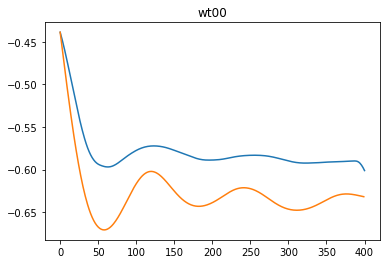

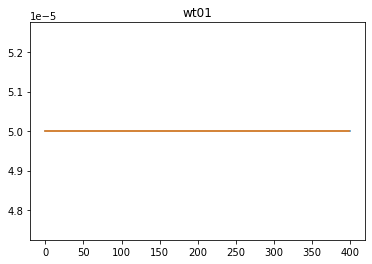

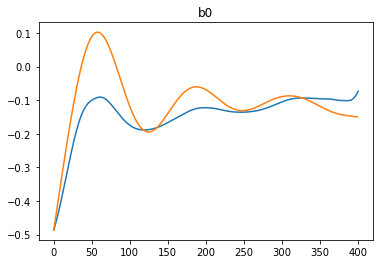

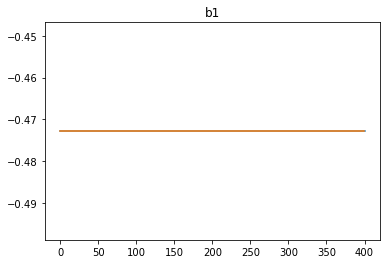

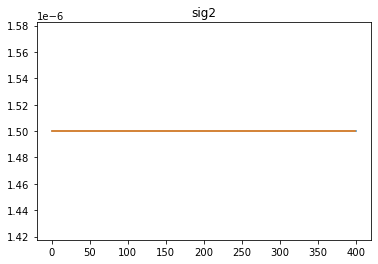

In [70]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
wt01 = [x.wt[0,1] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]
b1 = [x.b[1] for x in params_traj_int.params_traj]
sig2 = [x.sig2 for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
wt01_true = [x.wt[0,1] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]
b1_true = [x.b[1] for x in params_traj.params_traj]
sig2_true = [x.sig2 for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)
plt.title("wt00")

plt.figure()
plt.plot(wt01)
plt.plot(wt01_true)
plt.title("wt01")

plt.figure()
plt.plot(b0)
plt.plot(b0_true)
plt.title("b0")

plt.figure()
plt.plot(b1)
plt.plot(b1_true)
plt.title("b1")

plt.figure()
plt.plot(sig2)
plt.plot(sig2_true)
plt.title("sig2")

## Accuracy

In [20]:
def make_input_single(idx, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array([val[idx]])
    return in0

def make_output_single(idx, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array([val[idx]])
    return out0_norm_true

def make_input_multiple(idxs, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array(val[idxs])
    return in0

def make_output_multiple(idxs, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array(val[idxs])
    return out0_norm_true

def test_output_np(in0):
    out0_norm = model(in0)
    for key,val in out0_norm.items():
        out0_norm[key] = val.numpy()
    return out0_norm

In [21]:
idx = 15
in0 = make_input_single(idx, train_inputs)
out0_norm_true = make_output_single(idx, train_outputs_norm)

print("Input:",in0)
print("Output normalized true:",out0_norm_true)
out0_norm = test_output_np(in0)
print("Output true:", out0_norm)

Input: {'tpt': array([15.]), 'wt': array([[[-3.24692148e-01,  5.00000000e-05]]]), 'b': array([[-0.59687188, -0.68348013]]), 'sig2': array([1.5e-06])}
Output normalized true: {'wt00_TE': array([-3.37807944]), 'b0_TE': array([1.28487952])}
Output true: {'wt00_TE': array([[-3.3489437]], dtype=float32), 'b0_TE': array([[1.4640167]], dtype=float32)}


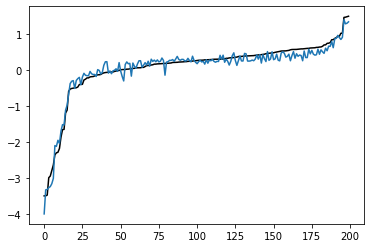

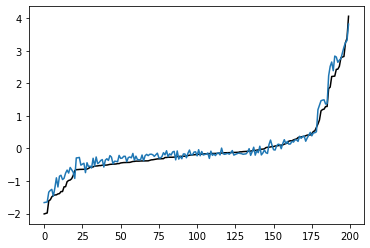

In [22]:
no_inputs = len(train_inputs["wt"])
idxs = np.arange(0,no_inputs)
np.random.shuffle(idxs)
idxs = idxs[:200]

in0 = make_input_multiple(idxs, train_inputs)
out0_norm_true = make_output_multiple(idxs, train_outputs_norm)
out0_norm = test_output_np(in0)

idxs_sort = out0_norm_true["wt00_TE"].argsort()
x_true = out0_norm_true["wt00_TE"][idxs_sort]
x = out0_norm["wt00_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

idxs_sort = out0_norm_true["b0_TE"].argsort()
x_true = out0_norm_true["b0_TE"][idxs_sort]
x = out0_norm["b0_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

## Latent representation learned

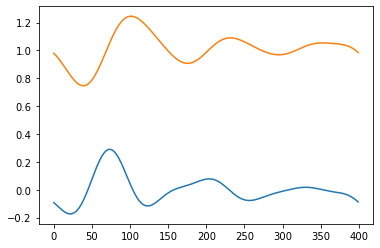

In [57]:
input0 = {
    "tpt": np.reshape(np.arange(0,400).astype('float32'),newshape=(400,1))
    }
muh_lyr = model_trained.compare_lyr.params0toParams.layer_muh["0"]
muh_output0 = muh_lyr(input0).numpy()
varh_diag_lyr = model_trained.compare_lyr.params0toParams.layer_varh_diag["0"]
varh_diag_output0 = varh_diag_lyr(input0).numpy()

plt.figure()
plt.plot(muh_output0)
plt.plot(varh_diag_output0)